### Reconstruct InSAR-PWV by COSMIC IPW 
using available NEVADA dataset as the test bed <br>
Must run on weather2 for package capability reasons...

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cfgrib
import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime, timedelta
import urllib.request
from cfgrib.xarray_store import open_dataset
import warnings
import h5py
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

RuntimeError: Cannot find the ecCodes library

In [ ]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def datetime_converter(year, day_num, hour):

# adjusting day num in a certain year into year, month, day, hour
# day_num = float
# year = float

    day_num.rjust(3 + len(day_num), '0')

    # Initializing start date
    strt_date = datetime(int(year), 1, 1)

    # converting to date
    res_date = strt_date + timedelta(days=int(day_num) - 1)
    res_time = res_date + timedelta(hours=int(hour))
    
    return res_time

In [5]:
datetime_converter('2017','16','02')

datetime.datetime(2017, 1, 16, 2, 0)

In [6]:
# get geolocation from InSAR
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
# for key in geo.keys():
#     print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]
axis_bound = [np.unique(lat.value)[1],np.unique(lat.value)[-1],np.unique(lon.value)[0],np.unique(lon.value)[-2]]

In [7]:
axis_bound

[37.228, 43.223568, -119.00549, -114.65358]

In [8]:
# reference date for InSAR data
date_ref = np.loadtxt('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/pic/reference_date.txt')
print(date_ref)

20171007.0


### 1. Get InSAR data at each acquisition 
post-processed in HRRR_timeseires.ipynb

In [9]:
data = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/InSAR_zenithdisp_NEVADA.nc')

In [10]:
data = data.sel(time=slice(datetime(2014,1,1),datetime(2019,12,31))) # for testing 

Text(0.5, 1.0, '2016-04-09T02:00:00')

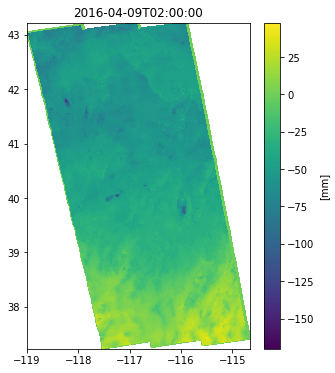

In [11]:
# total zenith delay 
fig = plt.figure(figsize=(5,6))
cf = plt.pcolormesh(data.longitude,data.latitude,data.disp_zenith[10,:,:]*100*10)
cbar = plt.colorbar(cf); cbar.set_label('[mm]')
plt.title(str(data.time[10].values)[:-10])

### 2. Get COSMIC-GPS data at each acquisition 

In [12]:
def merge_pkl_files(var_name, year):
    # var_name = variable name
    # year = [2015,2016..] list
    data_merged = pd.DataFrame()
    for yr in year:
        tmp = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/'+str(yr)+'/data_'+var_name+'.pkl')
        data_merged = data_merged.append(tmp, sort=False)
    return data_merged

In [13]:
stat_df = merge_pkl_files(var_name='statInfo',year=[2014,2015,2016,2017,2018,2019])
# remove duplicates in station index (same name but slightly different values in lon lat...)
stat_df = stat_df[~stat_df.index.duplicated(keep='first')]

pwv_df = merge_pkl_files(var_name='pwv',year=[2014,2015,2016,2017,2018,2019])
wet_delay_df = merge_pkl_files(var_name='wet_delay',year=[2014,2015,2016,2017,2018,2019])
dry_delay_df = merge_pkl_files(var_name='final_dry_delay',year=[2014,2015,2016,2017,2018,2019])
pifactor_df = merge_pkl_files(var_name='pifact',year=[2014,2015,2016,2017,2018,2019])

In [14]:
# complete timestamps of all dataframes (some missing days filled)
idx = pd.date_range(datetime(2014,1,2,0),datetime(2019,12,31,0),freq='1H')
pwv_df = pwv_df.reindex(idx,fill_value=np.nan)
wet_delay_df = wet_delay_df.reindex(idx,fill_value=np.nan)
dry_delay_df = dry_delay_df.reindex(idx,fill_value=np.nan)
pifactor_df = pifactor_df.reindex(idx,fill_value=np.nan)

In [15]:
# extract t02z data over CONUS stations
date_list = []
for date in data.time.values[data.time.values < np.datetime64(datetime(2019,12,31,0))]:
    date_list.append(datetime.utcfromtimestamp(date.astype(int) * 1e-9))
pwv_acqu = pwv_df.loc[date_list]
wet_delay_acqu = wet_delay_df.loc[date_list]
dry_delay_acqu = dry_delay_df.loc[date_list]
tot_delay_acqu = wet_delay_acqu + dry_delay_acqu
pifactor_acqu = pifactor_df.loc[date_list]

In [16]:
def station_acqu_subdomain(stat_df, axis_bound):
    # extract GPS data covered by the specified region
    
    stat_sub = stat_df.loc[stat_df['lat'].between(axis_bound[0],axis_bound[1]) & 
               stat_df['lon'].between(axis_bound[2],axis_bound[3])]

    return stat_sub

In [17]:
station_id_subdomain = station_acqu_subdomain(stat_df, axis_bound)
station_id_subdomain

,lon,lat
station,,
P002,-117.186531,39.521138
P005,-115.278628,39.910171
P007,-114.819713,41.724201
TONO,-117.184041,38.097194
BURN,-117.843530,42.779501
P098,-118.684415,39.888882
TUNG,-118.257506,40.403201
P013,-117.329994,41.428741
P630,-119.000443,37.613036


In [18]:
# point-wise comparison between GPS and InSAR zenith delay
tot_delay_sub = tot_delay_acqu[station_id_subdomain.index]
tot_delay_sub[tot_delay_sub<0] = np.nan
tot_delay_insar = data.disp_zenith

In [19]:
# point-wise comparison between GPS PWV
pwv_sub = pwv_acqu[station_id_subdomain.index]
pwv_sub[pwv_sub<0] = np.nan

In [20]:
# point-wise comparison between GPS PWV
pifactor_sub = pifactor_acqu[station_id_subdomain.index]
pifactor_sub[pifactor_sub<0] = np.nan

In [21]:
tot_delay_sub_insar = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    tmp = tot_delay_insar.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'disp_zenith': i})
    tot_delay_sub_insar = pd.concat([tot_delay_sub_insar,tmp],axis=1)

In [22]:
tot_delay_sub_insar.head(5)

,P002,P005,P007,TONO,BURN,P098,TUNG,P013,P630
time,,,,,,,,,
2015-03-22 02:00:00,-0.012208,-0.012136,NaN,0.001379,-0.026172,NaN,-0.006973,-0.020519,NaN
2015-04-03 02:00:00,-0.006203,-0.028367,NaN,0.000320,0.015861,NaN,0.004682,-0.002571,NaN
2015-04-15 02:00:00,0.004786,-0.012078,NaN,-0.003607,0.019307,NaN,0.006492,0.001573,NaN
2015-05-09 02:00:00,0.019610,0.013571,NaN,0.001539,0.001076,NaN,0.034679,0.048823,NaN
2015-06-26 02:00:00,-0.008396,0.029709,NaN,0.002130,0.040304,NaN,0.017697,0.025603,NaN


In [23]:
tot_delay_sub.tail(5)

,P002,P005,P007,TONO,BURN,P098,TUNG,P013,P630
2019-11-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-14 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-26 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


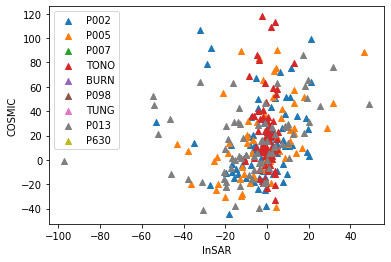

In [24]:
for i in station_id_subdomain.index.values[:]:
    tmp = tot_delay_sub_insar[i]*100*10 # insar total delay diff [mm]
    tmp2 = tot_delay_sub[i]-tot_delay_sub.loc[datetime(2017,10,7,2)][i] # COSMIC total delay diff
    
    plt.scatter(tmp,tmp2,marker='^',label=i)
plt.ylabel('COSMIC');plt.xlabel('InSAR')
plt.legend()

In [25]:
tot_delay_sub_insar.index[0]

Timestamp('2015-03-22 02:00:00')

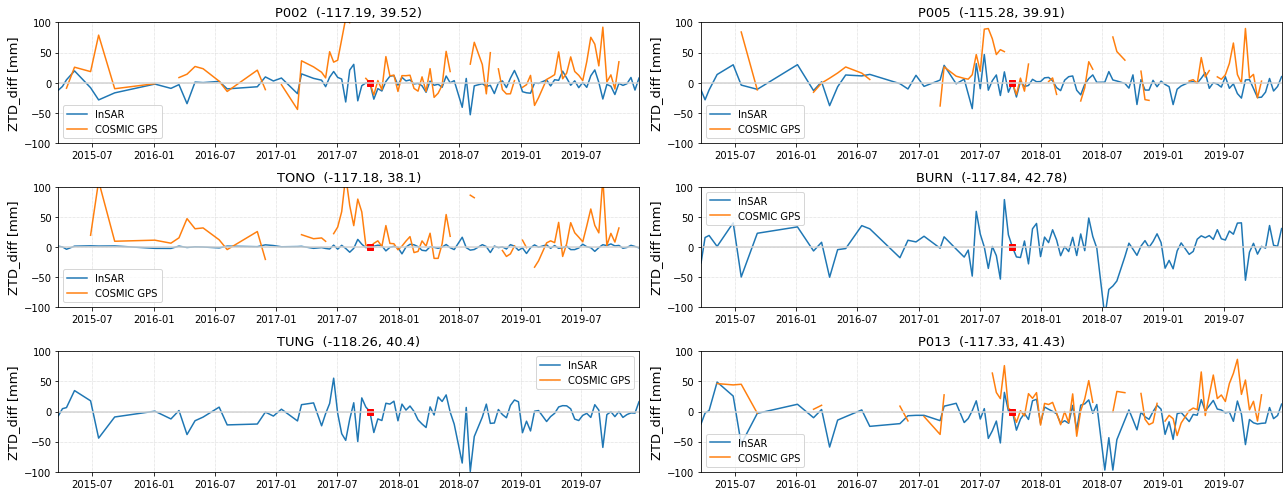

In [26]:
# sorted with time

station_avail = ['P002','P005','TONO','BURN','TUNG','P013']
nrow = [0,0,1,1,2,2]
ncol = [0,1,0,1,0,1]

fig,ax = plt.subplots(3,2,figsize=(18,7))

for i,stat in enumerate(station_avail):

    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,tot_delay_sub_insar[stat]*100*10)
    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,tot_delay_sub[stat]-tot_delay_sub.loc[datetime(2017,10,7,2)][stat])
    loc_str = ('  ('+str(round(station_id_subdomain.loc[stat]['lon'],2)) 
               +', '+str(round(station_id_subdomain.loc[stat]['lat'],2)) + ')')
    ax[nrow[i],ncol[i]].set_title(stat + loc_str,fontsize=13)
    ax[nrow[i],ncol[i]].set_ylabel('ZTD_diff [mm]',fontsize=13)
    ax[nrow[i],ncol[i]].set_ylim([-100,100])
    ax[nrow[i],ncol[i]].set_xlim([tot_delay_sub_insar.index[0],tot_delay_sub_insar.index[-1]])

    ax[nrow[i],ncol[i]].grid(linestyle=':',linewidth=0.5)
    ax[nrow[i],ncol[i]].legend(['InSAR','COSMIC GPS'])
    ax[nrow[i],ncol[i]].plot(datetime(2017,10,7,2),0,color='r',marker='s')
    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,np.zeros(len(tot_delay_sub_insar.index)),
                             color='lightgrey')
    
plt.tight_layout()
#fig.savefig('/data2/willytsai/InSAR_HRRR/InSAR_GPS_NEVADA_ZTD.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

### Adding back the offset romoved in Interferograms

In [27]:
tot_delay_df = wet_delay_df + dry_delay_df
tot_delay_TONO = tot_delay_sub['TONO']

In [28]:
#plt.plot(tot_delay_TONO,'r')
#plt.plot(tot_delay_sub['TONO']-tot_delay_sub.loc[datetime(2017,10,7,2)]['TONO'],'k')

In [29]:
# remove offset according to TONO (close to the reference point)
offset = (tot_delay_TONO-tot_delay_sub.loc[datetime(2017,10,7,2)]['TONO']) - tot_delay_sub_insar['TONO']*10*100

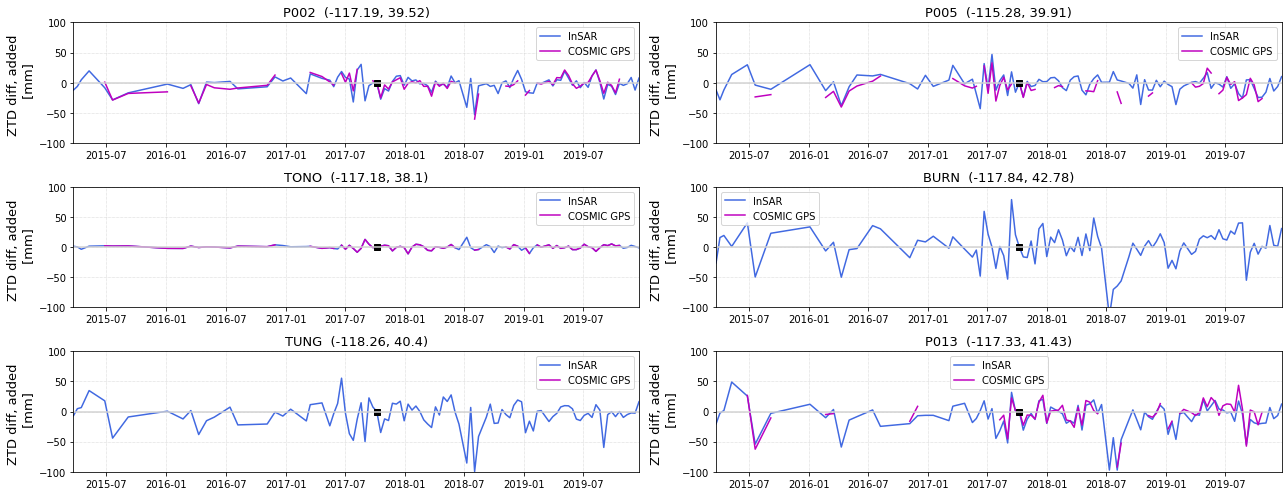

In [30]:
fig,ax = plt.subplots(3,2,figsize=(18,7))

for i,stat in enumerate(station_avail):

    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,tot_delay_sub_insar[stat]*100*10,color='royalblue')
    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,
                             tot_delay_sub[stat]-tot_delay_sub.loc[datetime(2017,10,7,2)][stat]-offset,color='m')
    loc_str = ('  ('+str(round(station_id_subdomain.loc[stat]['lon'],2)) 
               +', '+str(round(station_id_subdomain.loc[stat]['lat'],2)) + ')')
    ax[nrow[i],ncol[i]].set_title(stat + loc_str,fontsize=13)
    ax[nrow[i],ncol[i]].set_ylabel('ZTD diff, added \n [mm]',fontsize=13)
    ax[nrow[i],ncol[i]].set_ylim([-100,100])
    ax[nrow[i],ncol[i]].set_xlim([tot_delay_sub_insar.index[0],tot_delay_sub_insar.index[-1]])

    ax[nrow[i],ncol[i]].grid(linestyle=':',linewidth=0.5)
    ax[nrow[i],ncol[i]].legend(['InSAR','COSMIC GPS'])
    ax[nrow[i],ncol[i]].plot(datetime(2017,10,7,2),0,color='k',marker='s')
    ax[nrow[i],ncol[i]].plot(tot_delay_sub_insar.index,np.zeros(len(tot_delay_sub_insar.index)),
                             color='lightgrey')

plt.tight_layout()
#fig.savefig('/data2/willytsai/InSAR_HRRR/InSAR_GPS_NEVADA_ZTD_removeoffset.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

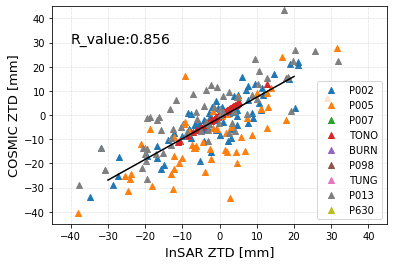

In [31]:
insar_rec = []; gps_rec = []

for i in station_id_subdomain.index.values[:]:
    tmp = tot_delay_sub_insar[i]*100*10 # insar total delay diff [mm]
    tmp2 = tot_delay_sub[i]-tot_delay_sub.loc[datetime(2017,10,7,2)][i]-offset # COSMIC total delay diff
        
    insar_rec.append(tmp.values)
    gps_rec.append(tmp2.values)
    
    plt.scatter(tmp,tmp2,marker='^',label=i)
plt.legend()
plt.ylabel('COSMIC zenith delay [mm]',fontsize=13)
plt.xlabel('InSAR zenith delay [mm]',fontsize=13)

insar_rec = np.array(insar_rec).ravel()
gps_rec = np.array(gps_rec).ravel()

tmp, tmp2 = [],[]
for i in range(len(insar_rec)):
    if np.isnan(insar_rec[i]) == False and np.isnan(gps_rec[i]) == False:
        tmp.append(insar_rec[i])
        tmp2.append(gps_rec[i])

r_stats = linregress(tmp,tmp2)
plt.plot(np.linspace(-30,20,51),r_stats.slope*np.linspace(-30,20,51)+r_stats.intercept,
        color='k')
plt.xlim([-45,45]);plt.ylim([-45,45])
plt.text(-40,30,'R_value:'+str(round(r_stats.rvalue,3)),fontsize=14)
plt.grid(linestyle=':',linewidth=0.5)
plt.ylabel('COSMIC ZTD [mm]');plt.xlabel('InSAR ZTD [mm]')
plt.legend()
#fig.savefig('/data2/willytsai/InSAR_HRRR/ZTD_removeoffset_scatterplot.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

In [32]:
# Loading HRRR Pi_factor
Pi_factor = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_Pi_factor_NEVADA.nc')

In [33]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [34]:
def remap_hrrr2SAR(hrrr_2dmap):
    "regrid hrrr data into SAR"
    lon_hrrr,lat_hrrr = np.meshgrid(hrrr_2dmap.longitude.values,hrrr_2dmap.latitude.values)
    lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
    points = np.stack([lon_hrrr.ravel(),lat_hrrr.ravel()]).swapaxes(0,1)
    var_remap = griddata(points, hrrr_2dmap.values.ravel(), (lon_isar, lat_isar), method='linear')

    return var_remap

In [35]:
# the reference point on InSAR map, near P002
data_ifgrams = h5py.File('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/S1_IW123_166_0121_0140_20150322_XXXXXXXX.he5', 'r')
geo_info = data_ifgrams['HDFEOS']['GRIDS']['timeseries']['geometry']
lon_ifgrams = geo_info['longitude']
lat_ifgrams = geo_info['latitude']

lon_sar = np.linspace(axis_bound[2],axis_bound[3],lon_ifgrams.shape[1])
lat_sar = np.linspace(axis_bound[0],axis_bound[1],lon_ifgrams.shape[0])

idx = find_nearest(lon_sar,-117.168465)
idy = find_nearest(lat_sar,38.228363)

In [148]:
# takes some time to estimate dry delay from HRRR 
data = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/HRRR_Psfc_NEVADA.nc')
ps_acqu = data.ps
ps_diff = ps_acqu-ps_acqu.sel(time=datetime(2017,10,7,2))
hydro_factor = 1e-6*0.776*287.15/9.8 # [m/pa]
sar_ps_diff = np.zeros((len(date_list),len(lat_sar),len(lon_sar)))

for t in range(sar_ps_diff.shape[0]):
    sar_ps_diff[t,:,:] = remap_hrrr2SAR(ps_diff[t,:,:]) # regrid pressure diff into sar grid

sar_dry_delay = hydro_factor*sar_ps_diff #[m/pa]*[pa]
sar_dry_delay = xr.DataArray(sar_dry_delay,dims=('time','latitude','longitude')
                            ,coords=(date_list,lat_sar,lon_sar),name='dry_delay')
sar_dry_delay = sar_dry_delay.to_dataset(name='dry_delay')

### estimated InSAR wet delay difference

In [151]:
wet_delay_diff_insar

<xarray.Dataset>
Dimensions:    (latitude: 2399, longitude: 1742, time: 99)
Coordinates:
  * latitude   (latitude) float64 37.23 37.23 37.23 37.24 ... 43.22 43.22 43.22
  * time       (time) datetime64[ns] 2015-03-22T02:00:00 ... 2019-12-20T02:00:00
  * longitude  (longitude) float64 -119.0 -119.0 -119.0 ... -114.7 -114.7 -114.7
Data variables:
    dry_delay  (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [155]:
# estimate the zenith wet delay by combining InSAR and atmospheric vars from HRRR (the above cell)
wet_delay_diff_insar = 100*10*(tot_delay_insar - sar_dry_delay) # [mm]
wet_delay_diff_insar = wet_delay_diff_insar.rename({'dry_delay': 'wet_delay'}) # rename for clarity 

In [156]:
# point-wise comparison between GPS PWV
wet_delay_sub = wet_delay_acqu[station_id_subdomain.index]
wet_delay_sub = wet_delay_sub.replace(-99.900002,np.nan)

In [157]:
wet_delay_diff_sub_insar = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    # find nearest point close to GPS stations
    tmp = wet_delay_diff_insar.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'wet_delay': i})
    wet_delay_diff_sub_insar = pd.concat([wet_delay_diff_sub_insar,tmp],axis=1)

In [158]:
dry_delay_diff_sub_insar = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    # find nearest point close to GPS stations
    tmp = sar_dry_delay.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'wet_delay': i})
    dry_delay_diff_sub_insar = pd.concat([dry_delay_diff_sub_insar,tmp],axis=1)

In [159]:
# adding HRRR ZWD_diff to compensate for missing GPS
pwv_diff_hrrr = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/HRRR_PW_diff_NEVADA.nc')
pwv_diff_hrrr = pwv_diff_hrrr.sel(time=slice(datetime(2014,1,1),datetime(2019,12,31)))
pwv_hrrr = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/google_archive/regrid_3km//HRRR_pwat_NEVADA.nc')
pwv_hrrr = pwv_hrrr.sel(time=slice(datetime(2014,1,1),datetime(2019,12,31)))

In [160]:
wet_delay_diff_hrrr = np.copy(tot_delay_insar)*np.nan

for t in range(len(date_list)):
    try:
        wet_delay_diff_hrrr[t,:,:] = remap_hrrr2SAR(pwv_diff_hrrr.pwat[t,:,:]*6.5)
    except:
        continue
wet_delay_diff_hrrr = xr.DataArray(wet_delay_diff_hrrr,dims=('time','latitude','longitude')
                            ,coords=(date_list,lat_sar,lon_sar),name='zenith_delay')
wet_delay_diff_hrrr = wet_delay_diff_hrrr.to_dataset(name='zenith_delay')

In [161]:
wet_delay_diff_sub_hrrr = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    tmp = wet_delay_diff_hrrr.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'zenith_delay': i})
    wet_delay_diff_sub_hrrr = pd.concat([wet_delay_diff_sub_hrrr,tmp],axis=1)

In [162]:
pwv_sub_hrrr = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    tmp = pwv_hrrr.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'pwat': i})
    pwv_sub_hrrr = pd.concat([pwv_sub_hrrr,tmp],axis=1)

In [163]:
offset

2015-03-22 02:00:00     3.420845
2015-04-03 02:00:00          NaN
2015-04-15 02:00:00    -4.893322
2015-05-09 02:00:00          NaN
2015-06-26 02:00:00    17.470100
                         ...    
2019-11-02 02:00:00          NaN
2019-11-14 02:00:00          NaN
2019-11-26 02:00:00          NaN
2019-12-08 02:00:00          NaN
2019-12-20 02:00:00          NaN
Name: TONO, Length: 99, dtype: float64

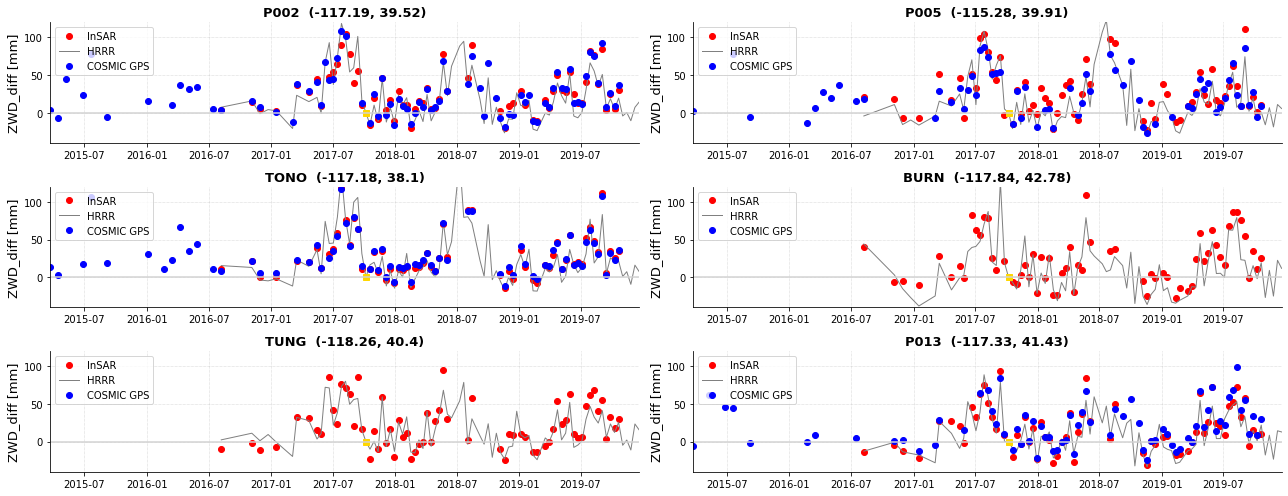

In [164]:
# ZWD_diff for GPS, HRRR and InSAR 

station_avail = ['P002','P005','TONO','BURN','TUNG','P013']
nrow = [0,0,1,1,2,2]
ncol = [0,1,0,1,0,1]

fig,ax = plt.subplots(3,2,figsize=(18,7))

for i,stat in enumerate(station_avail):
    
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_diff_sub_insar[stat] + offset , 'or') # original InSAR ZWD diff
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_diff_sub_hrrr[stat],'grey',linewidth=1) # original HRRR ZWD diff
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_sub[stat]-wet_delay_sub.loc[datetime(2017,10,7,2)][stat],'ob')
    loc_str = ('  ('+str(round(station_id_subdomain.loc[stat]['lon'],2)) 
               +', '+str(round(station_id_subdomain.loc[stat]['lat'],2)) + ')')
    ax[nrow[i],ncol[i]].set_title(stat + loc_str,fontsize=13, fontweight='bold')
    ax[nrow[i],ncol[i]].set_ylabel('ZWD_diff [mm]',fontsize=13)
    ax[nrow[i],ncol[i]].set_ylim([-40,120])

    ax[nrow[i],ncol[i]].grid(linestyle=':',linewidth=0.5)
    ax[nrow[i],ncol[i]].legend(['InSAR','HRRR','COSMIC GPS'],loc=2)
    ax[nrow[i],ncol[i]].plot(datetime(2017,10,7,2),0,color='gold',marker='s')
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,np.zeros(len(pwv_sub.index)),
                             color='lightgrey')
    ax[nrow[i],ncol[i]].set_xlim([date_list[0],date_list[-1]])
    ax[nrow[i],ncol[i]].spines['right'].set_visible(False)
    ax[nrow[i],ncol[i]].spines['top'].set_visible(False)

plt.tight_layout()
#fig.savefig('/data2/willytsai/InSAR_HRRR/ZWD_diff_timeseries.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

In [47]:
# adding local offset back to InSAR data based on GPS 
wet_delay_diff_insar_revised = np.empty(wet_delay_diff_insar.dry_delay.shape)

for i,t in enumerate(date_list):
    wet_delay_diff_insar_revised[i,:,:] = wet_delay_diff_insar.dry_delay.sel(time=t).values + offset.loc[t]
wet_delay_diff_insar_revised = xr.DataArray(wet_delay_diff_insar_revised,dims=('time','latitude','longitude')
                            ,coords=(date_list,lat_sar,lon_sar),name='disp_zenith') 
wet_delay_diff_insar_revised = wet_delay_diff_insar_revised.to_dataset(name='zenith_delay')

# == wet_delay_diff_sub_insar_re: corrected InSAR ZWD by a single GPS station == 
wet_delay_diff_sub_insar_re = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    tmp = wet_delay_diff_insar_revised.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'zenith_delay': i})
    wet_delay_diff_sub_insar_re = pd.concat([wet_delay_diff_sub_insar_re,tmp],axis=1)

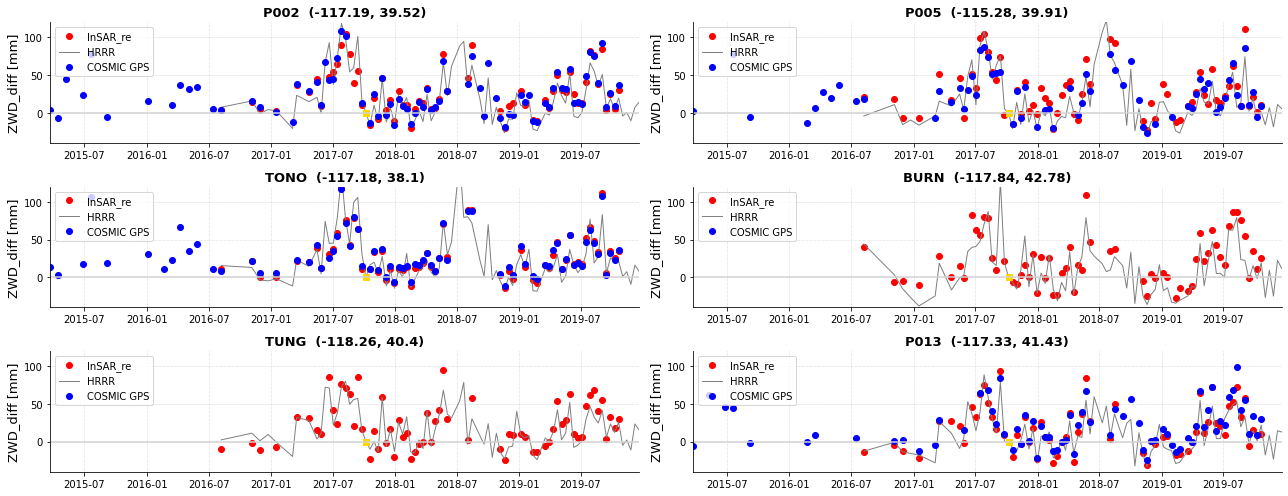

In [48]:
# ZWD_diff for GPS, HRRR and InSAR 

station_avail = ['P002','P005','TONO','BURN','TUNG','P013']
nrow = [0,0,1,1,2,2]
ncol = [0,1,0,1,0,1]

fig,ax = plt.subplots(3,2,figsize=(18,7))

for i,stat in enumerate(station_avail):
    
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_diff_sub_insar_re[stat], 'or') # corrected InSAR ZWD diff
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_diff_sub_hrrr[stat],'grey',linewidth=1) # original HRRR ZWD diff
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,wet_delay_sub[stat]-wet_delay_sub.loc[datetime(2017,10,7,2)][stat],'ob')
    loc_str = ('  ('+str(round(station_id_subdomain.loc[stat]['lon'],2)) 
               +', '+str(round(station_id_subdomain.loc[stat]['lat'],2)) + ')')
    ax[nrow[i],ncol[i]].set_title(stat + loc_str,fontsize=13, fontweight='bold')
    ax[nrow[i],ncol[i]].set_ylabel('ZWD_diff [mm]',fontsize=13)
    ax[nrow[i],ncol[i]].set_ylim([-40,120])

    ax[nrow[i],ncol[i]].grid(linestyle=':',linewidth=0.5)
    ax[nrow[i],ncol[i]].legend(['InSAR_re','HRRR','COSMIC GPS'],loc=2)
    ax[nrow[i],ncol[i]].plot(datetime(2017,10,7,2),0,color='gold',marker='s')
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,np.zeros(len(pwv_sub.index)),
                             color='lightgrey')
    ax[nrow[i],ncol[i]].set_xlim([date_list[0],date_list[-1]])
    ax[nrow[i],ncol[i]].spines['right'].set_visible(False)
    ax[nrow[i],ncol[i]].spines['top'].set_visible(False)

plt.tight_layout()
#fig.savefig('/data2/willytsai/InSAR_HRRR/ZWD_diff_timeseries.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

In [49]:
# remove offset to get relative ZWD reference to TONO and divided by pi_factor 
# to convert ZWD into PWV at the reference time and point

# PWV(x,t) = Pi*(ZDT(x,t) - ZDT(x,tref)) + PWV(x,tref)

pwv_diff_insar_test = wet_delay_diff_insar_revised/6.5 
pwv_sub_insar_test = pd.DataFrame()
for i in station_id_subdomain.index.values:
        
    lon_sel = station_id_subdomain.loc[i]['lon']
    lat_sel = station_id_subdomain.loc[i]['lat']
    tmp = pwv_diff_insar_test.sel(longitude=lon_sel,latitude=lat_sel,method='nearest')
    tmp = tmp.to_dataframe().drop(columns=['latitude','longitude']).rename(columns={'zenith_delay': i})
    # add pwv reference back to ZWD
    if np.isnan(pwv_sub.loc[datetime(2017,10,7,2)][i]) == False: # if GPS not available
        tmp2 = pwv_sub.loc[datetime(2017,10,7,2)][i]
    else: # using HRRR instead, making sure that we have a complete InSAR-derived PWV dataset
        tmp2 = pwv_sub_hrrr.loc[datetime(2017,10,7,2)][i]
    pwv_sub_insar_test = pd.concat([pwv_sub_insar_test,tmp.add(tmp2)],axis=1) # PW(x,tref) + DPWV(x,t)

### final outcome for PWV

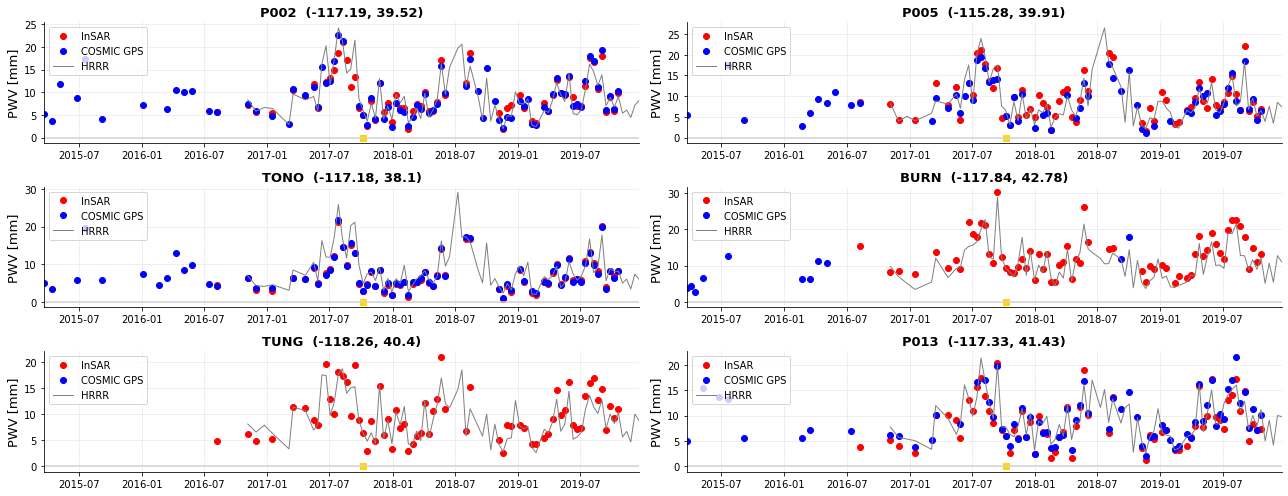

In [50]:
station_avail = ['P002','P005','TONO','BURN','TUNG','P013']
nrow = [0,0,1,1,2,2]
ncol = [0,1,0,1,0,1]

fig,ax = plt.subplots(3,2,figsize=(18,7))

for i,stat in enumerate(station_avail):
    
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,pwv_sub_insar_test[stat],'or')
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,pwv_sub[stat],'ob')
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,pwv_sub_hrrr[stat],'grey',linewidth=1)

    loc_str = ('  ('+str(round(station_id_subdomain.loc[stat]['lon'],2)) 
               +', '+str(round(station_id_subdomain.loc[stat]['lat'],2)) + ')')
    ax[nrow[i],ncol[i]].set_title(stat + loc_str,fontsize=13,fontweight='bold')
    ax[nrow[i],ncol[i]].set_ylabel('PWV [mm]',fontsize=13)
    
    ax[nrow[i],ncol[i]].grid(linestyle=':',linewidth=0.5)
    ax[nrow[i],ncol[i]].legend(['InSAR','COSMIC GPS','HRRR'])
    ax[nrow[i],ncol[i]].plot(datetime(2017,10,7,2),0,color='gold',marker='s')
    ax[nrow[i],ncol[i]].plot(pwv_sub.index,np.zeros(len(pwv_sub.index)),
                             color='lightgrey')
    ax[nrow[i],ncol[i]].set_xlim([date_list[0],date_list[-1]])
    ax[nrow[i],ncol[i]].spines['right'].set_visible(False)
    ax[nrow[i],ncol[i]].spines['top'].set_visible(False)

plt.tight_layout()
#fig.savefig('/data2/willytsai/InSAR_HRRR/PWV_abs_stations_timeseries.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

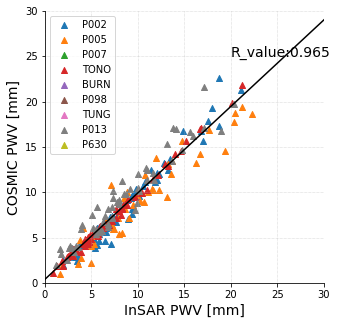

In [51]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

insar_rec = []; gps_rec = []; 

for i in station_id_subdomain.index.values[:]:
    tmp = pwv_sub_insar_test[i] # insar derived PWV
    tmp2 = pwv_sub[i] # COSMIC PWV
        
    insar_rec.append(tmp.values)
    gps_rec.append(tmp2.values)
    
    plt.scatter(tmp,tmp2,marker='^',label=i)
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

insar_rec = np.array(insar_rec).ravel()
gps_rec = np.array(gps_rec).ravel()

tmp, tmp2 = [],[]
for i in range(len(insar_rec)):
    if np.isnan(insar_rec[i]) == False and np.isnan(gps_rec[i]) == False:
        tmp.append(insar_rec[i])
        tmp2.append(gps_rec[i])

r_stats = linregress(tmp,tmp2)
ax.plot(np.linspace(-30,30,51),r_stats.slope*np.linspace(-30,30,51)+r_stats.intercept,
        color='k')

ax.set_xlim([0,30]);ax.set_ylim([0,30])
ax.text(20,25,'R_value:'+str(round(r_stats.rvalue,3)),fontsize=14)
ax.grid(linestyle=':',linewidth=0.5)
ax.set_ylabel('COSMIC PWV [mm]',fontsize=14);ax.set_xlabel('InSAR PWV [mm]',fontsize=14)
ax.legend()
#fig.savefig('/data2/willytsai/InSAR_HRRR/InSAR_GPS_PWV_scatterplot.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

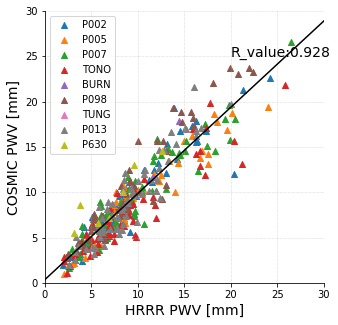

In [52]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

hrrr_rec = []; gps_rec = []; 

for i in station_id_subdomain.index.values[:]:
    tmp = pwv_sub_hrrr[i] # insar derived PWV
    tmp2 = pwv_sub[i] # COSMIC PWV
        
    hrrr_rec.append(tmp.values)
    gps_rec.append(tmp2.values)
    
    ax.scatter(tmp,tmp2,marker='^',label=i)
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

hrrr_rec = np.array(hrrr_rec).ravel()
gps_rec = np.array(gps_rec).ravel()

tmp, tmp2 = [],[]
for i in range(len(hrrr_rec)):
    if np.isnan(hrrr_rec[i]) == False and np.isnan(gps_rec[i]) == False:
        tmp.append(hrrr_rec[i])
        tmp2.append(gps_rec[i])

r_stats = linregress(tmp,tmp2)
ax.plot(np.linspace(-30,30,51),r_stats.slope*np.linspace(-30,30,51)+r_stats.intercept,
        color='k')

ax.set_xlim([0,30]);ax.set_ylim([0,30])
ax.text(20,25,'R_value:'+str(round(r_stats.rvalue,3)),fontsize=14)
ax.grid(linestyle=':',linewidth=0.5)
ax.set_ylabel('COSMIC PWV [mm]',fontsize=14);ax.set_xlabel('HRRR PWV [mm]',fontsize=14)
plt.legend()
#fig.savefig('/data2/willytsai/InSAR_HRRR/HRRR_GPS_PWV_scatterplot.pdf',dpi=200,
#           bbox_inches='tight',facecolor='white', transparent=False)

In [53]:
# # create InSAR-derived dataset
# pwv_insar_abs = np.copy(wet_delay_diff_insar)
# pwv_hrrr_ref = pwv_hrrr.sel(time=datetime(2017,10,7,2)).pwat
# pwv_hrrr_ref_remap = remap_hrrr2SAR(pwv_hrrr_ref)

In [54]:
# for i,t in enumerate(date_list):
#     pwv_insar_abs[i,:,:] = wet_delay_diff_insar_revised[i,:,:]/6.5 + pwv_hrrr_ref_remap[:,:]
# pwv_insar_abs = xr.DataArray(pwv_insar_abs,dims=('time','latitude','longitude')
#                             ,coords=(date_list,lat_sar,lon_sar),name='pwat')
# pwv_insar_abs.to_dataset(name='pwat')

### Output InSAR-PWV 

In [55]:
# pwv_insar_abs.to_netcdf('/data2/willytsai/InSAR_HRRR/InSAR_derived_PWV_NEVADA.nc')

### testing area
using correction by multiple GPS stations (Mateus et al., 2007)<br>
The $\Delta$PWV map obtained in each swath is calibrated to solve the arbitrary phase constant and possible orbits errors.
We may have to subjectively select an area which covers most GPS stations and overalpped pixels at k and k+1 compuatble for the matrix solver.

In [56]:
station_id_subdomain

,lon,lat
station,,
P002,-117.186531,39.521138
P005,-115.278628,39.910171
P007,-114.819713,41.724201
TONO,-117.184041,38.097194
BURN,-117.843530,42.779501
P098,-118.684415,39.888882
TUNG,-118.257506,40.403201
P013,-117.329994,41.428741
P630,-119.000443,37.613036


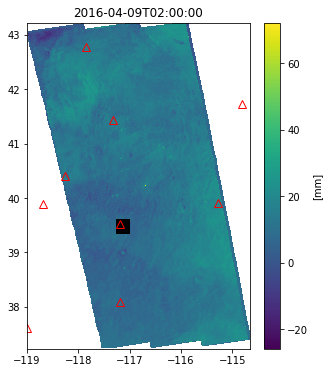

In [57]:
# total zenith delay 
fig = plt.figure(figsize=(5,6))
cf = plt.pcolormesh(wet_delay_diff_insar.longitude,wet_delay_diff_insar.latitude
                    ,wet_delay_diff_insar.dry_delay[49,:,:])
cbar = plt.colorbar(cf); cbar.set_label('[mm]')
plt.title(str(data.time[10].values)[:-10])

tmp,tmp2 = np.meshgrid(wet_delay_diff_insar.longitude[700:800],wet_delay_diff_insar.latitude[850:950])
plt.plot(tmp,tmp2, color='k');

#cbar = plt.colorbar(cf); cbar.set_label('[mm]')
for stat in station_id_subdomain.index:
    tmp = station_id_subdomain.loc[stat].lon
    tmp2 =  station_id_subdomain.loc[stat].lat
    plt.plot(tmp,tmp2,'^',markersize=8, markerfacecolor='None', color='r')

In [189]:
# creating matrix for the least mean sqaure solution 
k=49
# Z(j,k) = DPWV_gps - 1/N*sum(DPWV_insar), here using only collocated GPS becasue of rare GPS stations.
Zk = (wet_delay_sub.iloc[k]-wet_delay_sub.loc[datetime(2017,10,7,2)]) - wet_delay_diff_sub_insar.iloc[k]
Zk1 = (wet_delay_sub.iloc[k+1]-wet_delay_sub.loc[datetime(2017,10,7,2)]) - wet_delay_diff_sub_insar.iloc[k+1]

# zeta(k,k+1) = InSAR interferograms
zeta = wet_delay_diff_insar.wet_delay[k,850:950,700:800] - wet_delay_diff_insar.wet_delay[k+1,850:950,700:800] # 100x100 pixels


In [190]:
lam = wet_delay_diff_insar.longitude.values[700:800] # longitude 
phi = wet_delay_diff_insar.latitude.values[850:950] # latitiude

lam_m, phi_m = np.meshgrid(lam,phi)

In [191]:
# submatrix for m pixels at k
Y1 = zeta.values.ravel() # shape: m, zeta_1...m, k, k+1
c1 = np.ones(len(Y1)) # column one in the second matrix in paper
c2 = phi_m.ravel()
c3 = lam_m.ravel()*np.cos(phi_m.ravel()/180*np.pi) # lambda_k*cos(phi_k)
c4 = -np.ones(len(Y1))
c5 = -phi_m.ravel()
c6 = -lam_m.ravel()*np.cos(phi_m.ravel()/180*np.pi) 
A1 = np.vstack([c1,c2,c3,c4,c5,c6]).swapaxes(0,1) # shape: m x 6 

# GPS stations, k+1
Y2 = Zk1
c1 = np.zeros((len(Y2),3))
n = 1
for stat in Y2.index:
    tmp = station_id_subdomain.loc[stat].lat
    tmp2 = station_id_subdomain.loc[stat].lon
    if n is 1:
        c2 = np.array([1, tmp, tmp2*np.cos(tmp/180*np.pi)])
        n+=1
    else:
        c2 = np.vstack([c2,[1, tmp, tmp2*np.cos(tmp/180*np.pi)]])
A2 = np.hstack([c1,c2]) # stacking horizontally

# GPS stations, k
Y3 = Zk
c2 = np.zeros(((len(Y3),3)))
n = 1
for stat in Y3.index:
    tmp = station_id_subdomain.loc[stat].lat
    tmp2 = station_id_subdomain.loc[stat].lon
    if n is 1:
        c1 = np.array([1, tmp, tmp2*np.cos(tmp/180*np.pi)])
        n+=1
    else:
        c1 = np.vstack([c1,[1, tmp, tmp2*np.cos(tmp/180*np.pi)]])
A3 = np.hstack([c1,c2]) # stacking horizontally

# merge all submatrix to solve the equation set
Y_all = np.concatenate([Y1,Y2,Y3])
A_all = np.vstack([A1,A2,A3])


In [192]:
idx_nan = np.where(~np.isnan(Y_all))[0] # nan index
sigma_assume = np.concatenate([np.ones(len(Y1))*1.5,np.ones(len(Y2)+len(Y3))])
C = np.diag(sigma_assume[idx_nan])

# removing NAN in the full matrix 
idx_nan = np.where(~np.isnan(Y_all))[0]
Y_ava = Y_all[idx_nan]
A_ava = A_all[idx_nan,:]

In [193]:
X1 = np.linalg.inv(np.linalg.multi_dot([A_ava.T, C, A_ava]))
X = np.linalg.multi_dot([X1,A_ava.T,C,Y_ava])

In [194]:
X

array([ 1264.30787182,    -7.95084894,    10.55659283, -1391.49005365,
          10.09423251,   -11.0973543 ])

In [195]:
wet_delay_diff_correct = (wet_delay_diff_insar.wet_delay[k,850:950,700:800] 
                                            + X[0] + X[1]*phi_m + X[2]*lam_m*np.cos(phi_m/180*np.pi))

In [196]:
wet_delay_diff_P002 = wet_delay_sub['P002'].iloc[k]-wet_delay_sub['P002'].loc[datetime(2017,10,7,2)]

In [224]:
wet_delay_diff_P002_insar = wet_delay_diff_insar_revised.sel(longitude=-117.19,latitude=39.52,method='nearest').zenith_delay[k]

GPS delta_ZWD: 31.199999 
InSAR_revised delta_ZWD: 32.720412826692424


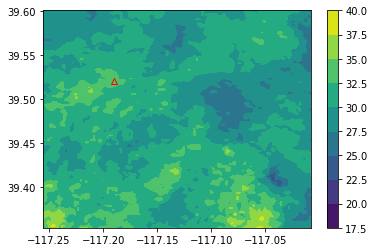

In [235]:
# Correction by single GPS as proposed
wet_delay_diff_singleGPS = wet_delay_diff_insar_revised.zenith_delay[k,850:950,700:800]

plt.contourf(wet_delay_diff_insar.longitude[700:800],wet_delay_diff_insar.latitude[850:950],
             wet_delay_diff_singleGPS)
plt.colorbar()
plt.plot(-117.19,39.52,'^',markerfacecolor='None', color='r')
print('GPS delta_ZWD:',wet_delay_diff_P002,'\n'
      'InSAR_revised delta_ZWD:',wet_delay_diff_P002_insar.values)

31.199999 32.720412826692424


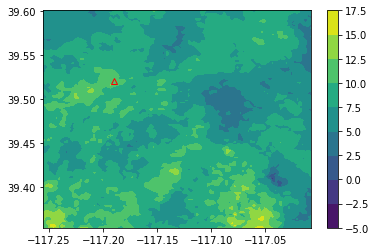

In [227]:
# Original Interferograms SAR
plt.contourf(wet_delay_diff_insar.longitude[700:800],wet_delay_diff_insar.latitude[850:950],
             wet_delay_diff_insar.wet_delay[k,850:950,700:800])
plt.colorbar()
plt.plot(-117.19,39.52,'^',markerfacecolor='None', color='r')

In [242]:
wet_delay_diff_P002_Mateus = wet_delay_diff_correct.sel(longitude=-117.19,latitude=39.52,method='nearest')

GPS delta_ZWD: 31.199999 
 InSAR_revised delta_ZWD: 6.081787664980311


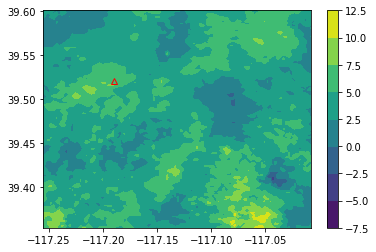

In [245]:
# Corrected by Mateus's method 
plt.contourf(wet_delay_diff_insar.longitude[700:800],wet_delay_diff_insar.latitude[850:950],
             wet_delay_diff_correct)
plt.colorbar()
plt.plot(-117.19,39.52,'^',markerfacecolor='None', color='r')
print('GPS delta_ZWD:',wet_delay_diff_P002,'\n',
      'InSAR_revised delta_ZWD:',wet_delay_diff_P002_Mateus.values)